In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings

warnings.filterwarnings('ignore')
np.random.seed(7)

In [2]:
# Load all datasets
datasets = {
    'Petrignano': pd.read_csv('../data/ACEA/Aquifer_Petrignano.csv'),
    'Auser': pd.read_csv('../data/ACEA/Aquifer_Auser.csv'),
    'Doganella': pd.read_csv('../data/ACEA/Aquifer_Doganella.csv'),
    'Luco': pd.read_csv('../data/ACEA/Aquifer_Luco.csv'),
    'Bilancino': pd.read_csv('../data/ACEA/Lake_Bilancino.csv'),
    'Arno': pd.read_csv('../data/ACEA/River_Arno.csv'),
    'Amiata': pd.read_csv('../data/ACEA/Water_Spring_Amiata.csv'),
    'Lupa': pd.read_csv('../data/ACEA/Water_Spring_Lupa.csv'),
    'Madonna': pd.read_csv('../data/ACEA/Water_Spring_Madonna_di_Canneto.csv')
}

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [3]:
# Preprocess data function
def preprocess_data(df, date_column='Date', date_format='%d/%m/%Y'):
    df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    df = df.dropna().set_index(date_column).sort_index(ascending=True)
    differenced_series = df.diff().dropna()
    return df, differenced_series

# Data split function
def split_data(differenced_series, test_size=0.10):
    df_reset = differenced_series.reset_index()
    train_df, test_df = train_test_split(df_reset, test_size=test_size, shuffle=False)
    train_df.set_index('Date', inplace=True)
    test_df.set_index('Date', inplace=True)
    return train_df, test_df

# Function to calculate the maximum lag
def calculate_max_lag(data, fraction=0.1):
    return max(1, int(len(data) * fraction))

# Train the VAR model with error handling for small datasets
def train_var_model(train_df, fraction=0.1):
    max_lag = calculate_max_lag(train_df, fraction=fraction)
    max_lag = min(max_lag, len(train_df) // 2)
    model = VAR(train_df)
    
    try:
        lag_order = model.select_order(maxlags=max_lag)
        optimal_lag = lag_order.aic
    except ValueError as e:
        print(f"Error encountered: {e}")
        print(f"Adjusting max_lag to smaller value due to limited observations.")
        optimal_lag = min(max_lag, 1)

    print(f"Optimal Lag selected: {optimal_lag}")
    model_fitted = model.fit(optimal_lag)
    return model_fitted, optimal_lag

# Forecast and revert differencing
def forecast_data(model_fitted, train_df, num_forecast, last_observation):
    num_lag = model_fitted.k_ar
    forecast = model_fitted.forecast(train_df.values[-num_lag:], steps=num_forecast)
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns)
    forecast_reverted = forecast_df.cumsum().add(last_observation, axis=1)
    return forecast_reverted

# Evaluate the model
def evaluate_model(test_df, forecast_df, features):
    mae = mean_absolute_error(test_df[features], forecast_df[features])
    mse = mean_squared_error(test_df[features], forecast_df[features])
    rmse = np.sqrt(mse)
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
    return mae, mse, rmse

# Visualize forecast vs. actual data
def visualize_forecast(test_df, forecast_df, original_df, features):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(20, 5*len(features)))
    plt.subplots_adjust(hspace=0.5)

    for idx, feature in enumerate(features):
        sns.lineplot(x=test_df.index, y=test_df[feature], ax=axes[idx], color='dodgerblue', label='Actual')
        sns.lineplot(x=forecast_df.index, y=forecast_df[feature], ax=axes[idx], color='orange', linestyle='-', label='Forecast')
        
        axes[idx].set_title(f'Feature: {feature}', fontsize=16, weight='bold')
        axes[idx].set_ylabel(feature, fontsize=14)
        axes[idx].set_xlim([original_df.index.min(), forecast_df.index.max()])
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axes[idx].xaxis.set_major_locator(mdates.YearLocator())
        axes[idx].grid(True)
        axes[idx].legend()

    axes[-1].set_xlabel('Date', fontsize=14)
    plt.show()

print("Utility functions defined successfully.")

Utility functions defined successfully.



Processing Petrignano dataset

Optimal Lag selected: 373
MAE: 26.989780451420426, MSE: 729.8251448436589, RMSE: 27.015276138578685


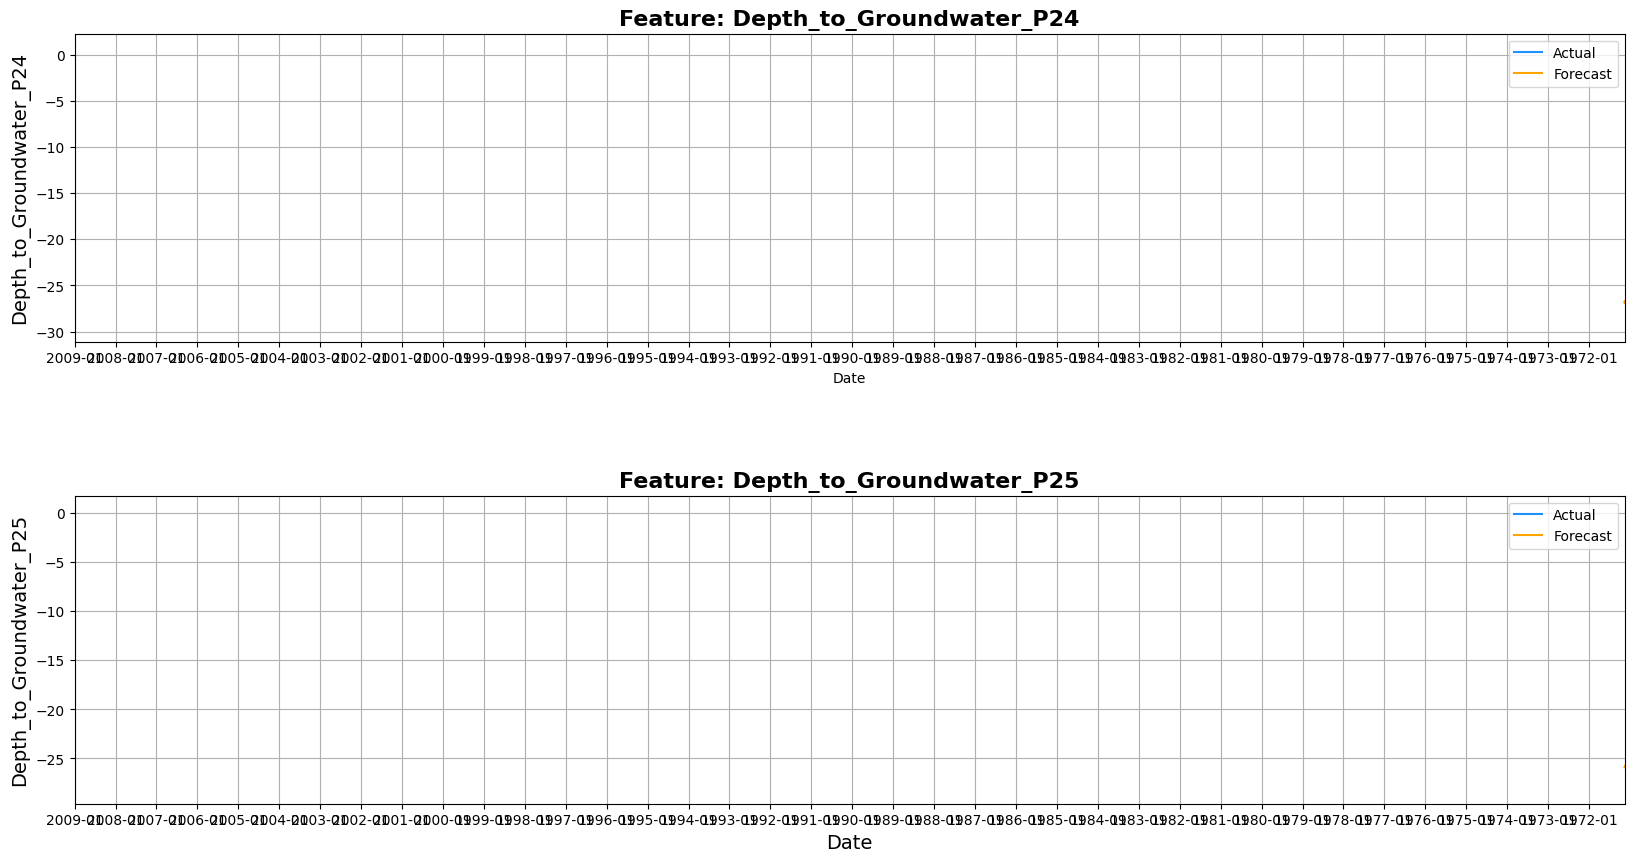

Finished processing Petrignano dataset.

Processing Auser dataset

Error encountered: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Adjusting max_lag to smaller value due to limited observations.
Optimal Lag selected: 1
MAE: 5.961026545276139, MSE: 48.17093706111926, RMSE: 6.9405285865789255


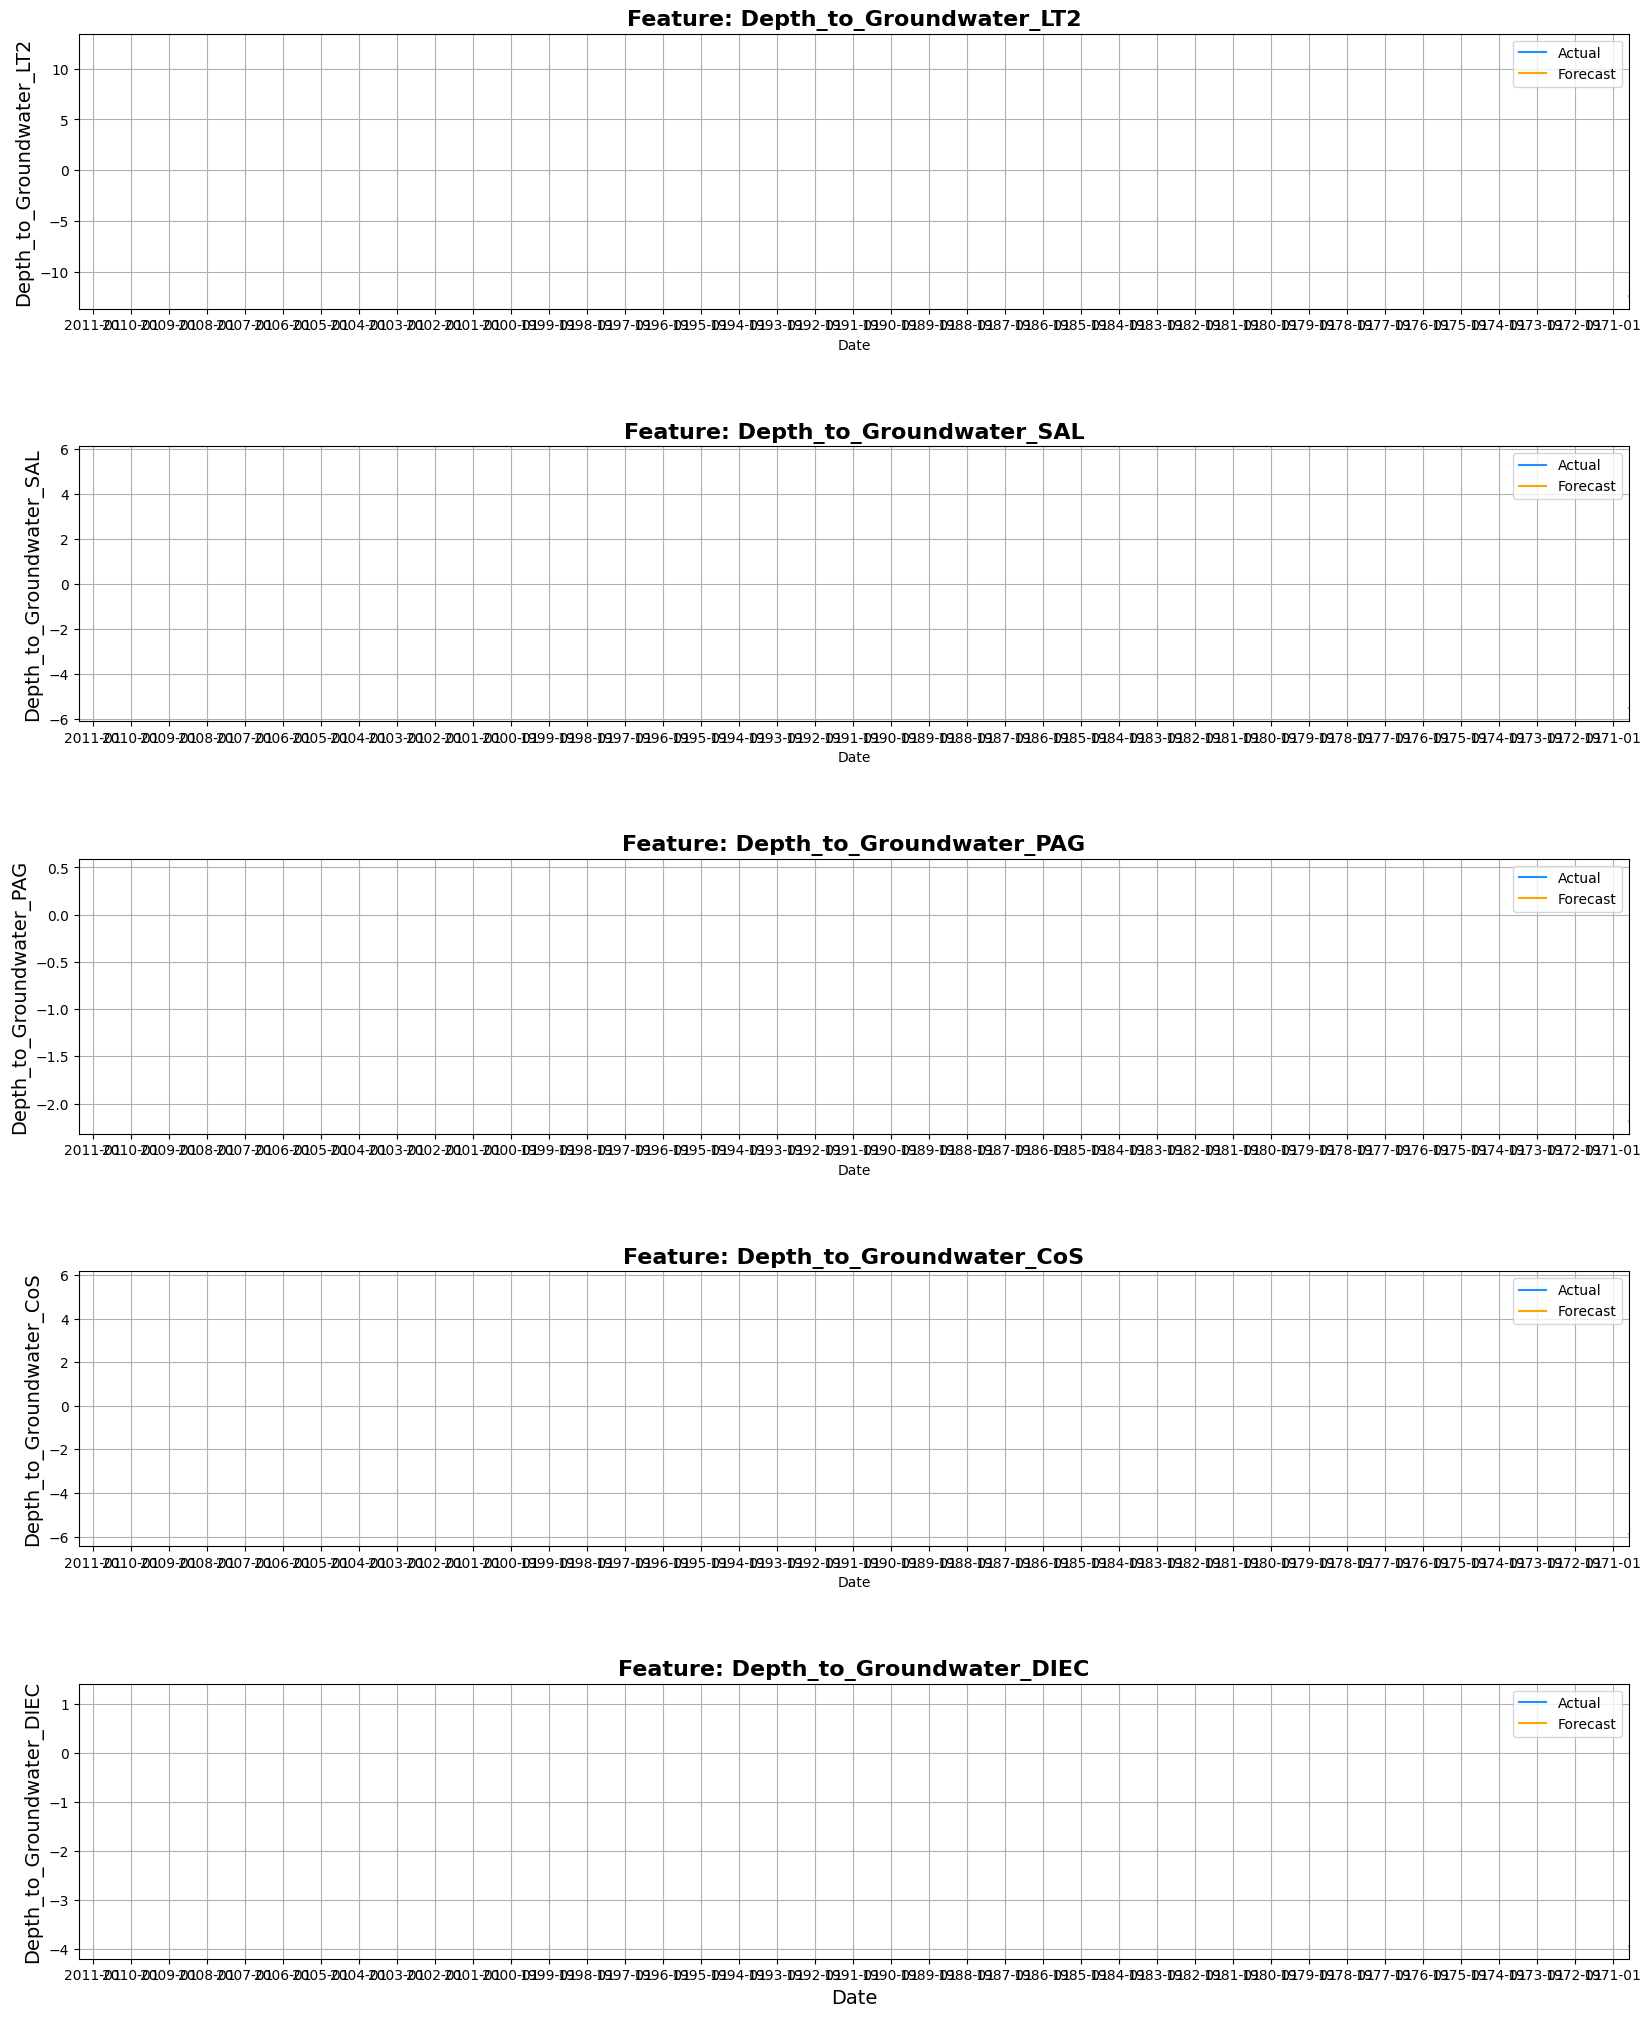

Finished processing Auser dataset.

Processing Doganella dataset

Error encountered: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Adjusting max_lag to smaller value due to limited observations.
Optimal Lag selected: 1
MAE: 93.5764298007127, MSE: 8989.072407337313, RMSE: 94.81071884200284


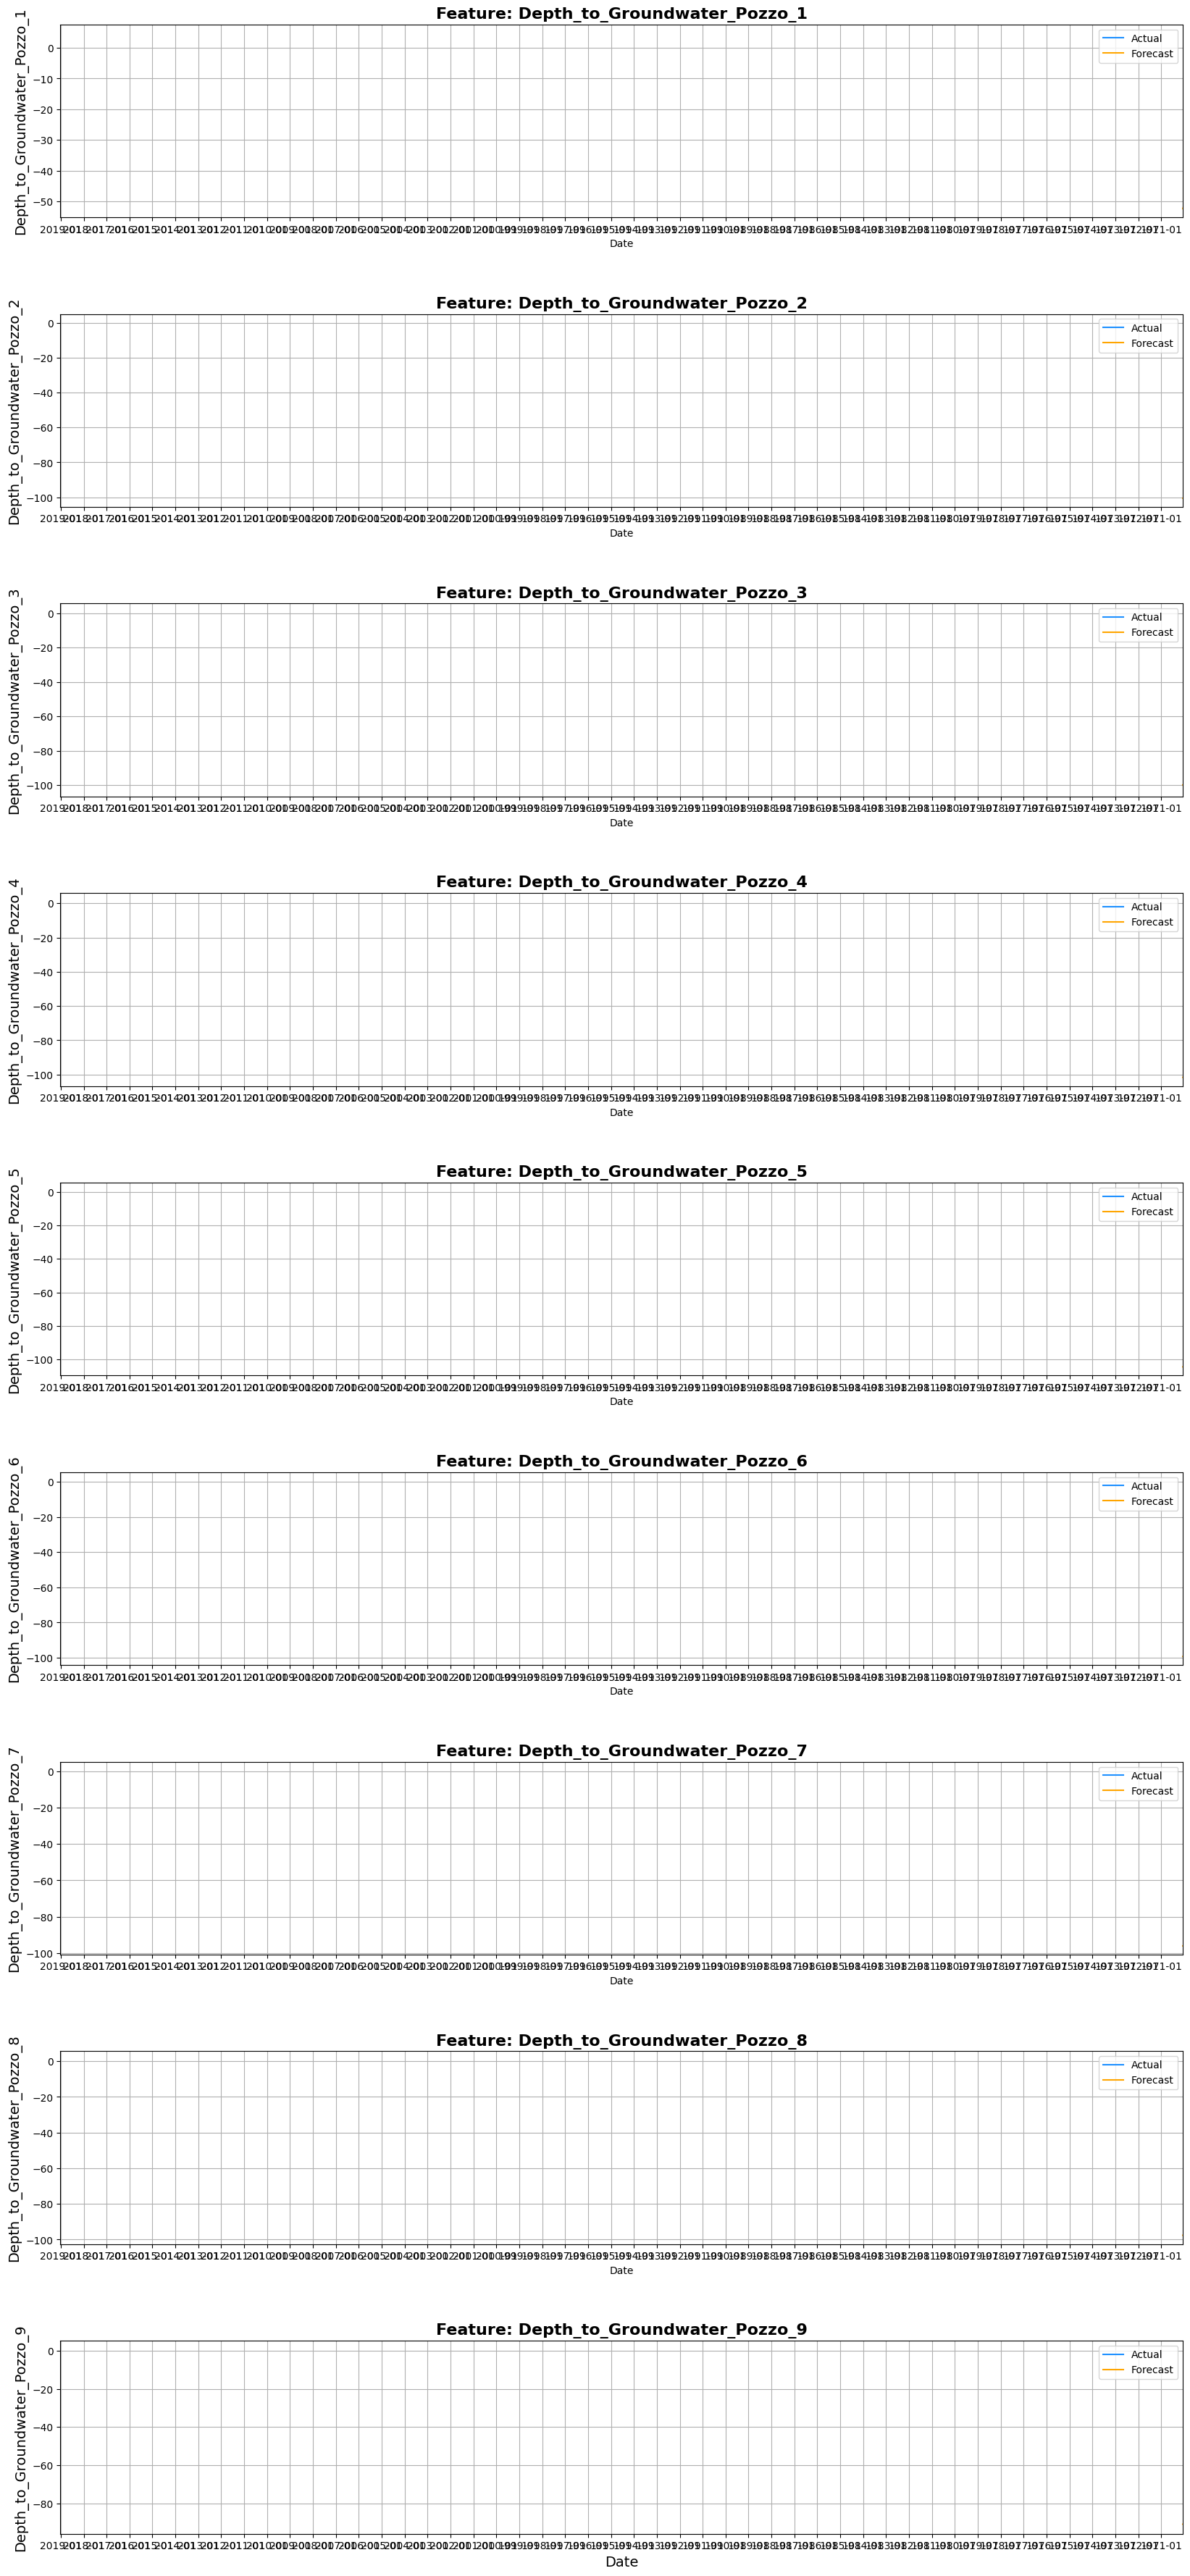

Finished processing Doganella dataset.

Processing Luco dataset

Error encountered: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Adjusting max_lag to smaller value due to limited observations.
Optimal Lag selected: 1
MAE: 10.198698976171064, MSE: 108.35578158527079, RMSE: 10.409408320614135


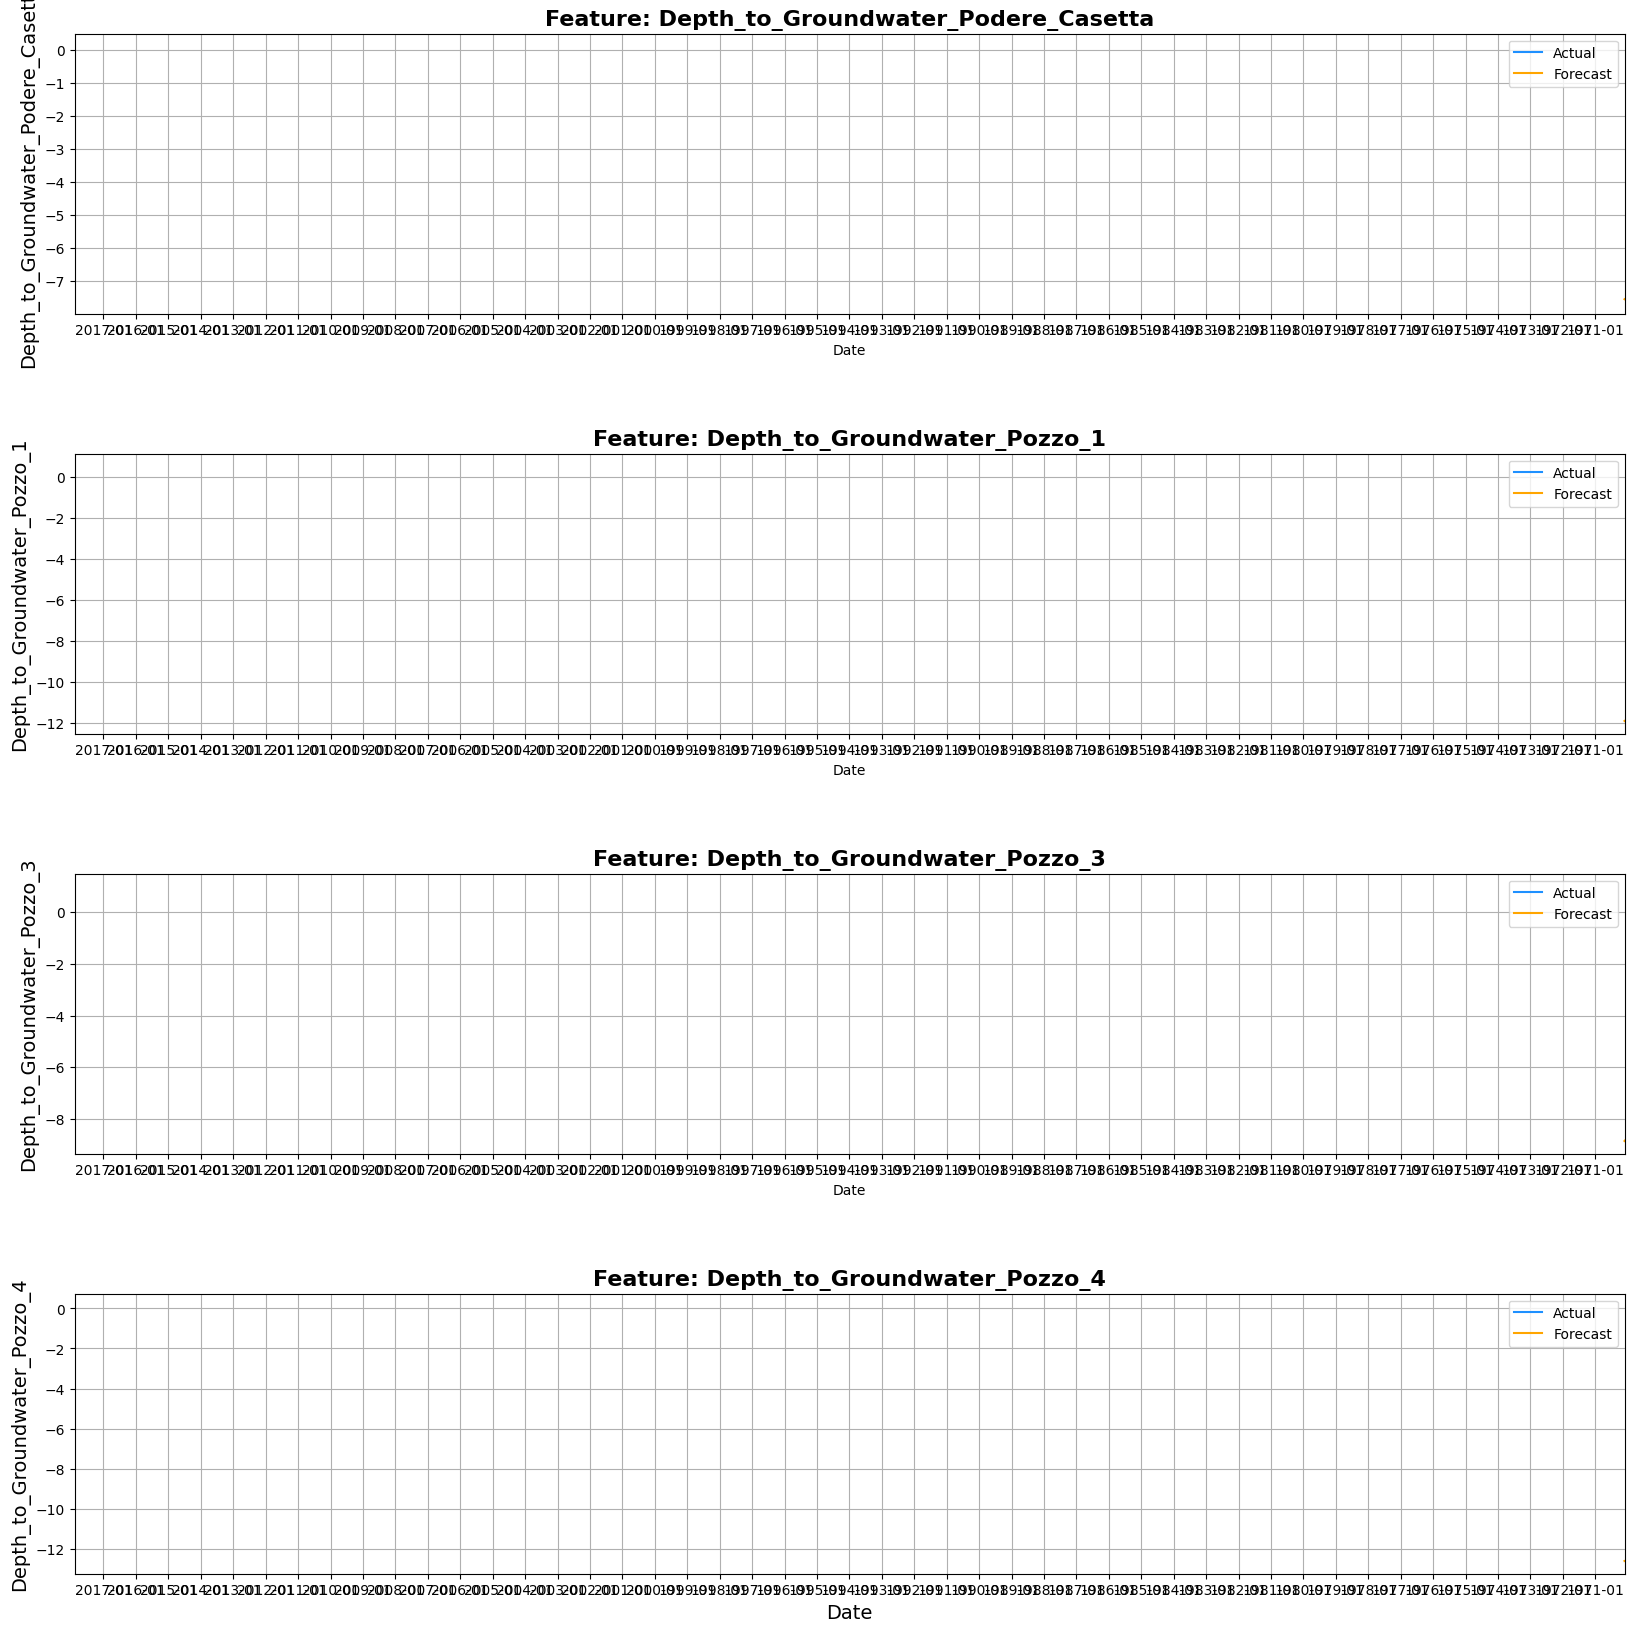

Finished processing Luco dataset.

Processing Bilancino dataset



In [ ]:
for name, df in datasets.items():
    print(f"\nProcessing {name} dataset\n")

    # Preprocess the data
    df, differenced_series = preprocess_data(df)
    
    # Split the data
    train_df, test_df = split_data(differenced_series)
    
    # Train the VAR model
    model_fitted, optimal_lag = train_var_model(train_df)
    
    # Forecasting
    num_forecast = len(test_df)
    last_observation = df.iloc[-1]
    forecast_reverted = forecast_data(model_fitted, train_df, num_forecast, last_observation)
    
    # Evaluate the model
    features_to_evaluate = [col for col in train_df.columns if 'Depth_to_Groundwater' in col]  # Example features
    mae, mse, rmse = evaluate_model(test_df, forecast_reverted, features_to_evaluate)
    
    # Visualize actual vs. forecasted data
    visualize_forecast(test_df, forecast_reverted, df, features_to_evaluate)
    
    print(f"Finished processing {name} dataset.")